# **Importing the libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import string
from string import digits
import re

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

# **Read Data into a dataframe**

In [3]:
data= pd.read_table('spa.txt',  names =['English', 'Spanish', 'Comments'])
# data = data[:10000]
data.sample(10)

,English,Spanish,Comments
59853,The moon has no atmosphere.,La Luna no tiene atmósfera.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
75495,Where is the end of this line?,¿Dónde está el final de esta fila?,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
2122,He is tired.,Él está cansado.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
17464,Show me that list.,Muéstrame esa lista.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
118307,"If you want to work here, you need a permit.","Si quieres trabajar aquí, necesitas un permiso.",CC-BY 2.0 (France) Attribution: tatoeba.org #3...
120847,Tom warned Mary not to go out at night alone.,Tom le advirtió a María que no fuera sola de n...,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
37956,I am taking a bath now.,Ahora me estoy dando un baño.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
87016,My guess is that it'll rain soon.,Supongo que lloverá pronto.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
137412,The bad thing about inferiority complexes is t...,Lo malo de los complejos de inferioridad es qu...,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
102301,Tom has you to thank for his success.,Tom tiene que agradecerte por su éxito.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...


In [4]:
data.English = data.English.apply(lambda word: word.lower())
data.Spanish = data.Spanish.apply(lambda word: word.lower())

# **Remove Special characters**

In [5]:
data.English = data.English.apply(lambda word: re.sub("'", '', word))
data.Spanish = data.Spanish.apply(lambda word: re.sub("'", '', word))

In [6]:
Punctuations = set(string.punctuation)
data.English = data.English.apply(lambda word: ''.join(char for char in word if char not in Punctuations))
data.Spanish = data.Spanish.apply(lambda word: ''.join(char for char in word if char not in Punctuations))

In [7]:
num_digits = str.maketrans('', '', digits)
data.English = data.English.apply(lambda x: x.translate(num_digits))
data.Spanish = data.Spanish.apply(lambda x: x.translate(num_digits))

# **Remove extra spaces**

In [8]:
data.English = data.English.apply(lambda spaces: spaces.strip())
data.Spanish = data.Spanish.apply(lambda spaces: spaces.strip())

In [9]:
data.English=data.English.apply(lambda x: re.sub(" +", " ", x))
data.Spanish=data.Spanish.apply(lambda x: re.sub(" +", " ", x))

# **Add start and end token to target sentence**

In [10]:
data.Spanish = data.Spanish.apply(lambda sentence : 'START_ '+ sentence + ' _END')
data.sample(10)

,English,Spanish,Comments
58123,i expected better from you,START_ esperaba más de vos _END,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
14357,this is your key,START_ ésta es tu llave _END,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
29859,its still too early,START_ todavía es demasiado temprano _END,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
4207,tom got sick,START_ tom se enfermó _END,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
124562,i hope you wont mind if i give you some advice,START_ espero que no te importe que te dé algu...,CC-BY 2.0 (France) Attribution: tatoeba.org #7...
49788,please visit me tomorrow,START_ por favor venga a visitarme mañana _END,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
82016,i thought we were out of coffee,START_ pensé que no nos quedaba café _END,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
103711,i go to sleep at ten almost every day,START_ me duermo a las diez casi todos los día...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
136825,we learn from experience that men never learn ...,START_ de la experiencia aprendemos que el hom...,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
92148,tom has no idea why mary did that,START_ tom no tiene idea de por qué mary hizo ...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...


# **Create Vocuabaly of English and Spanish words**

In [11]:
English_words = set()
for English in data.English:
    for word in English.split():
        if word not in English_words:
            English_words.add(word)


Spanish_words=set()
for Spanish in data.Spanish:
    for word in Spanish.split():
        if word not in Spanish_words:
            Spanish_words.add(word)


English_words = sorted(list(English_words))
Spanish_words = sorted(list(Spanish_words))

# **Maximum length for padding**

In [12]:
English_length_list=[]
for sentence in data.English:
    English_length_list.append(len(sentence.split(' ')))
max_English_length= max(English_length_list)
print(" Max length of the English sentence",max_English_length)

Spanish_length_list=[]
for sentence in data.Spanish:
    Spanish_length_list.append(len(sentence.split(' ')))
max_Spanish_length= max(Spanish_length_list)
print(" Max length of the Spanish sentence",max_Spanish_length)

 Max length of the English sentence 70
 Max length of the Spanish sentence 70


# **Word to index and vice versa dictionary**

In [13]:
English_word2idx = dict([(word, index+1) for index, word in enumerate(English_words)])
Spanish_word2idx = dict([(word, index+1) for index, word in enumerate(Spanish_words)])
vocab_size_Spanish = len(Spanish_word2idx) + 1

In [14]:
English_idx2word = dict([(index, word) for word, index in  English_word2idx.items()])
Spanish_idx2word = dict([(index, word) for word, index in Spanish_word2idx.items()])

# print(English_idx2word, Spanish_idx2word)

# **Shuffle the data to get randomness**

In [15]:
#Shuffle the data
data = shuffle(data)

# **Split into train and test**

In [16]:
x, y = data.English, data.Spanish
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1)
x_train.shape, x_test.shape

((124596,), (13844,))

In [17]:
num_encoder_tokens = len(English_words)
num_decoder_tokens = len(Spanish_words) + 1

# **Function to generate batches of data**

In [18]:
def generate_batch(X = x_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for batches in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_English_length),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_Spanish_length),dtype='float32')
            decoder_Spanish_data = np.zeros((batch_size, max_Spanish_length, num_decoder_tokens),dtype='float32')
            for i, (input_text, Spanish_text) in enumerate(zip(X[batches:batches+batch_size], y[batches:batches+batch_size])):
                for t, word in enumerate(input_text.split()):
                  encoder_input_data[i, t] = English_word2idx[word] 
                for t, word in enumerate(Spanish_text.split()):
                    if t<len(Spanish_text.split())-1:
                        decoder_input_data[i, t] = Spanish_word2idx[word]
                    if t>0:
                        decoder_Spanish_data[i, t - 1, Spanish_word2idx[word]] = 1.
                    
            yield([encoder_input_data, decoder_input_data], decoder_Spanish_data)

In [19]:
latent_dim = 256 # number of nodes in NN

# **Set up the encoder input and LSTM architecture**

In [20]:
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)


encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

encoder_states = [state_h, state_c]

# **The decoder architecture to follow**

In [21]:
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [22]:
decoder_outputs

<KerasTensor: shape=(None, None, 28735) dtype=float32 (created by layer 'dense')>

# **Concatenate with attention layer**

In [23]:
# from tensorflow.keras.layers import AdditiveAttention, Concatenate, TimeDistributed

In [24]:
encoder_outputs, decoder_outputs

(<KerasTensor: shape=(None, None, 256) dtype=float32 (created by layer 'lstm_2')>,
 <KerasTensor: shape=(None, None, 28735) dtype=float32 (created by layer 'dense')>)

In [25]:
# attention_result = AdditiveAttention(use_scale=True)([encoder_outputs, decoder_outputs])

# decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_result])

In [26]:
# decoder_dense = Dense(num_decoder_tokens, activation='softmax')
# decoder_outputs = decoder_dense(decoder_outputs)

In [27]:
# decoder_dense = TimeDistributed(Dense(vocab_size_Spanish, activation= 'softmax'))
# decoder_outputs = decoder_dense(decoder_concat_input)

# **Defining the model**

In [28]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [29]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

In [30]:
import tensorflow as tf

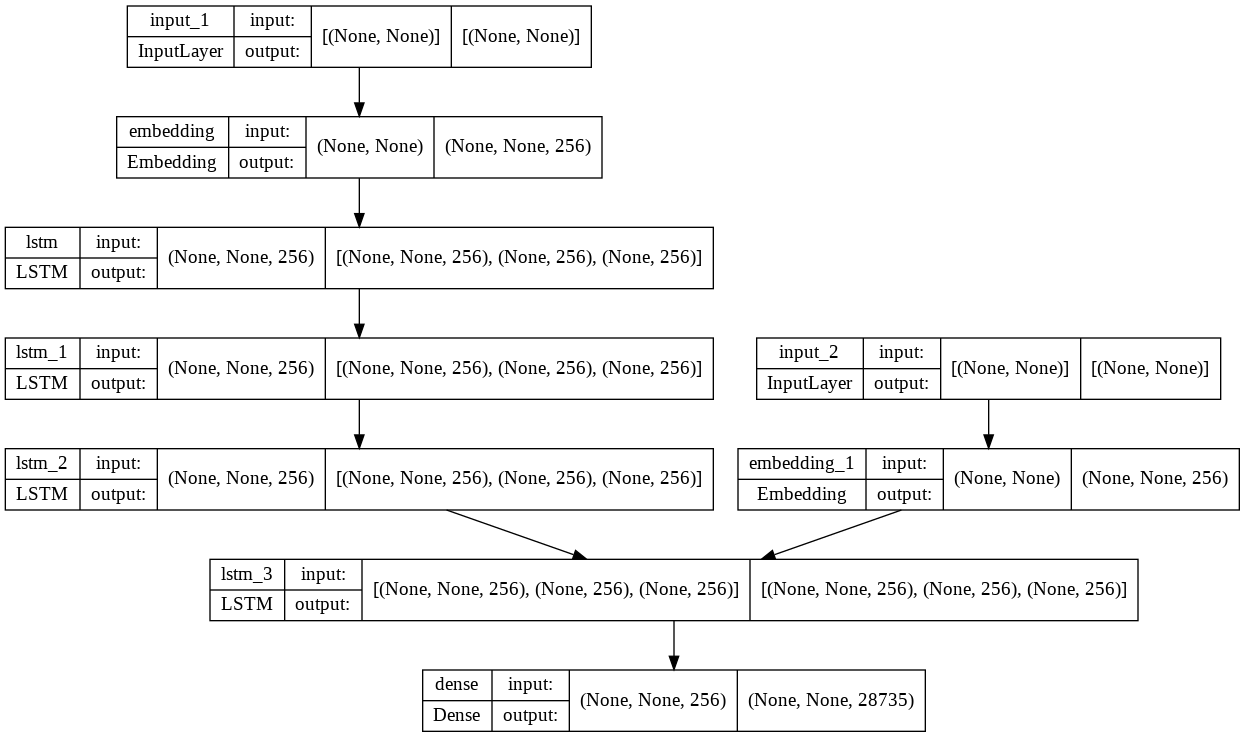

In [31]:
tf.keras.utils.plot_model(model, to_file = "model.png", show_shapes = True)

In [32]:
train_samples = len(x_train)
val_samples = len(x_test)
batch_size = 128
epochs = 12

# **Training the model**

In [33]:
# model.fit_generator(generator = generate_batch(x_train, y_train, batch_size = batch_size),
#                     steps_per_epoch = train_samples//batch_size,
#                     epochs=epochs,
#                     validation_data = generate_batch(x_test, y_test, batch_size = batch_size),
#                     validation_steps = val_samples//batch_size)

# **Saving the h5 file**

In [34]:
# model.save_weights('nmt_weights_12epoch.h5')

In [36]:
model.load_weights('nmt_weights_12epochs.h5')

# **The inference set up**

In [37]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_state_input = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_state_input)
decoder_states2 = [state_h2, state_c2]

decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model([decoder_inputs] + decoder_state_input, [decoder_outputs2] + decoder_states2)

# **Decoding the numerical value into text**

In [38]:
def decode_sequence(input_seq):
  
    states_value = encoder_model.predict(input_seq)
    
    Spanish_seq = np.zeros((1,1))
    
    Spanish_seq[0, 0] = Spanish_word2idx['START_']
    
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([Spanish_seq] + states_value)
        
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word =Spanish_idx2word[sampled_token_index]
        decoded_sentence += ' '+ sampled_word
        
        if (sampled_word == '_END' or len(decoded_sentence) > 50):
            stop_condition = True
            
        Spanish_seq = np.zeros((1,1))
        Spanish_seq[0, 0] = sampled_token_index
        
        states_value = [h, c]
    return decoded_sentence

# **Predicting on the training dataset**

In [39]:
train_gen = generate_batch(x_train, y_train, batch_size = 1)
k=-1

In [47]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)

print('Input English sentence:', x_train[k:k+1].values[0])
print('Actual Spanish Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Spanish Translation:', decoded_sentence[:-4])

Input English sentence: im not sure where tom is from
Actual Spanish Translation:  no estoy seguro de dónde viene tom 
Predicted Spanish Translation:  no estoy seguro de dónde está tom 


# **Predicting on the custom input sentence**

In [41]:
infer_sentence= "how are you"
input_sentence = np.zeros((1, max_English_length),dtype='float32')
for t, word in enumerate(infer_sentence.split()):
  input_sentence[0, t] = English_word2idx[word]
decoded_sentence = decode_sequence(input_sentence)
print(decoded_sentence[:-4])

 ¿cómo estás 
